In [ ]:
from copy import deepcopy
from pathlib import Path
from pprint import pprint 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.width", 110)

In [2]:
import datetime as dt
from joblib import Memory
import pickle
from shutil import rmtree

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV, 
    StratifiedKFold,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.pipeline import Pipeline

from sksurv.util import Surv
from sksurv.linear_model import CoxnetSurvivalAnalysis

from lib.pipeline_helpers import fit_and_score_features
from lib.plotting import plot_kaplan_meier

set_config(display="text")  # displays text representation of estimators

In [3]:
import warnings
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning

warnings.simplefilter("ignore", UserWarning) # e.g. suppress wanrings such as UserWarning: all coefficients are zero, consider decreasing alpha.
warnings.simplefilter("ignore", FitFailedWarning)
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
# local paths
data_dir_proc = Path('data/preprocess')
data_dir_eda = Path('data/eda')
results_dir = Path('results')
Path(results_dir).mkdir(parents=True, exist_ok=True)

# load data

In [5]:
survival = pd.read_parquet(data_dir_proc / 'survival.parquet')
print(survival.head())
print(survival.shape)

                     _PATIENT  OS  OS.time  DSS  DSS.time  DFI  DFI.time  PFI  PFI.time  Redaction
TCGA-69-7978-01  TCGA-69-7978   0    134.0  0.0     134.0  NaN       NaN    0     134.0        NaN
TCGA-62-8399-01  TCGA-62-8399   0   2696.0  0.0    2696.0  0.0    2696.0    0    2696.0        NaN
TCGA-78-7539-01  TCGA-78-7539   0    791.0  0.0     791.0  1.0     688.0    1     688.0        NaN
TCGA-73-4658-01  TCGA-73-4658   1   1600.0  0.0    1600.0  0.0    1600.0    0    1600.0        NaN
TCGA-44-6775-01  TCGA-44-6775   0    705.0  0.0     705.0  1.0     684.0    1     684.0        NaN
(506, 10)


In [6]:
clinical_cat = pd.read_parquet(Path(data_dir_eda) / 'clinical_cat.parquet')
clinical_num = pd.read_parquet(Path(data_dir_eda) / 'clinical_num.parquet')
clinical = clinical_cat.merge(clinical_num, how='inner', left_index=True, right_index=True)
print(clinical.head())
print(clinical.shape)

                 gender icd_o_3_histology icd_o_3_site other_dx pathologic_M  ... stopped_smoking_year tobacco_smoking_history year_of_initial_pathologic_diagnosis year_of_tobacco_smoking_onset tumour_volume
TCGA-69-7978-01    MALE            8255/3        C34.1       No      UNKNOWN  ...                  NaN     2_former_smoker<15y                               2011.0                           NaN           NaN
TCGA-62-8399-01    MALE            8255/3        C34.1       No           M0  ...                  NaN          4_never_smoked                               2006.0                           NaN           NaN
TCGA-78-7539-01  FEMALE            8255/3        C34.1       No           M0  ...               1981.0    3_former_smoker>=15y                               2011.0                        1953.0         0.504
TCGA-73-4658-01  FEMALE            8140/3        C34.3      Yes           M0  ...                  NaN    3_former_smoker>=15y                               2004.0     

In [7]:
expression = pd.read_parquet(Path(data_dir_eda) / 'expression.parquet')
print(expression.head())
print(expression.shape)

                 ARHGEF10L    HIF3A    RNF10    RNF11    RNF13  ...     PTRF   BCL6B    GSTK1    SELP     SELS
TCGA-69-7978-01     9.9898   4.2598  10.3657  11.1718  10.5897  ...  12.7565  8.2668  11.2400  6.1209   9.8977
TCGA-62-8399-01    10.4257  11.6239  11.5489  11.0200   9.2843  ...  12.2100  8.5437  10.3491  8.6398   9.7315
TCGA-78-7539-01     9.6264   9.1362  11.6692  10.4679  10.4649  ...  10.6498  6.1814  11.1659  6.0970  10.3540
TCGA-73-4658-01     9.2078   5.0288  11.6209  11.3414  10.9376  ...  13.0036  8.9786  10.6777  8.4187  10.3142
TCGA-44-6775-01    10.0039   4.0573  11.1721  11.0969  10.9337  ...  12.7727  7.5911  10.3340  7.3311  10.0039

[5 rows x 16104 columns]
(506, 16104)


In [8]:
event_col = 'OS'
time_col = 'OS.time'
clinical_cat_cols = clinical.select_dtypes(include=['object', 'category', 'bool']).columns.to_list()
clinical_num_cols = clinical.select_dtypes(include=np.number).columns.to_list()
expression_cols = expression.columns
# expression_cols = expression.columns[:500].to_series()

In [9]:
y = Surv.from_dataframe(event=event_col, time=time_col, data=survival)
print(y.shape)
print(pd.DataFrame.from_records(y).head())
print(f'overall censoring rate: {(~y[event_col]).mean():.3}')

(506,)
      OS  OS.time
0  False    134.0
1  False   2696.0
2  False    791.0
3   True   1600.0
4  False    705.0
overall censoring rate: 0.638


In [10]:
X = clinical.loc[:, clinical_cat_cols + clinical_num_cols]\
    .merge(expression.loc[:, expression_cols], how='inner', left_index=True, right_index=True)
print(X.shape)
print(X.head())

(506, 16125)
                 gender icd_o_3_histology icd_o_3_site other_dx pathologic_M  ...     PTRF   BCL6B    GSTK1    SELP     SELS
TCGA-69-7978-01    MALE            8255/3        C34.1       No      UNKNOWN  ...  12.7565  8.2668  11.2400  6.1209   9.8977
TCGA-62-8399-01    MALE            8255/3        C34.1       No           M0  ...  12.2100  8.5437  10.3491  8.6398   9.7315
TCGA-78-7539-01  FEMALE            8255/3        C34.1       No           M0  ...  10.6498  6.1814  11.1659  6.0970  10.3540
TCGA-73-4658-01  FEMALE            8140/3        C34.3      Yes           M0  ...  13.0036  8.9786  10.6777  8.4187  10.3142
TCGA-44-6775-01  FEMALE            8140/3        C34.1       No      UNKNOWN  ...  12.7727  7.5911  10.3340  7.3311  10.0039

[5 rows x 16125 columns]


# pipeline

In [11]:
cachedir = "./.cache"
memory = Memory(location=cachedir, verbose=0)

clinical_cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='~OTHER')),
    ('encode', OneHotEncoder(drop='if_binary', sparse_output=False)),
    ('varthresh', VarianceThreshold(threshold=0.01)),
    ('select', SelectKBest(fit_and_score_features, k=5))
])

clinical_num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median', add_indicator=True)),
    ('varthresh', VarianceThreshold(threshold=1e-5)),
    ('scale', StandardScaler()),
    ('select', SelectKBest(fit_and_score_features, k=5))
])

expression_pipe = Pipeline([
    ('varthresh', VarianceThreshold(threshold=1e-5)),
    ('scale', StandardScaler()),
    ('select', PCA(svd_solver="randomized", random_state=42)),
])

preprocess_pipe = ColumnTransformer([
    ('clinical_cat', clinical_cat_pipe, clinical_cat_cols),
    ('clinical_num', clinical_num_pipe, clinical_num_cols),
    ('expression', expression_pipe, expression_cols),
])

coxnet_pipe = Pipeline([
    ('preprocess', preprocess_pipe),
    ('coxnet', CoxnetSurvivalAnalysis(max_iter=10000))
], memory=memory)

# params

alpha | l1_ratio | model
----- | -------- | ---
`0`     |          | ordinary regression (OLS?)
`>0`    | 0        | ridge
`>0`    | 1        | lasso

## l1_ratios

In [12]:
# make l1_ratios list and check bounds 
n_l1_ratios = 3
l1_ratios = np.linspace(0.1, 0.9, n_l1_ratios) # 0=Ridge, 1=Lasso
print(len(l1_ratios))
pprint(l1_ratios)

3
array([0.1, 0.5, 0.9])


# alphas

In [13]:
# make alphas list and check bounds 
n_alphas = 5
min_alpha = 0.01
max_alpha = 0.1
alphas = [float(x) for x in np.logspace(np.log(min_alpha), np.log(max_alpha), n_alphas, base=np.exp(1))]
# alphas = [float(x) for x in np.logspace(-3, 0.2, n_alphas)]
print(len(alphas))
pprint(alphas)
alphas = [[x] for x in alphas] # the alphas parameter expects a list

5
[0.010000000000000007,
 0.017782794100389243,
 0.031622776601683805,
 0.05623413251903494,
 0.10000000000000003]


In [14]:
params = {
    # "preprocess__expression__varthresh__threshold": [1.5],
    "preprocess__expression__varthresh__threshold": [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5],
    "preprocess__expression__select__n_components": [5, 10, 15, 20],
#    "preprocess__clinical_cat__impute__strategy": ['constant', 'most_frequent'],
    "preprocess__clinical_cat__impute__strategy": ['constant'],
    "preprocess__clinical_cat__select__k": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "preprocess__clinical_num__select__k": [0, 1, 2, 3],
    "coxnet__l1_ratio": l1_ratios,
    "coxnet__alphas": alphas,  
}

# classifier

In [15]:
cv = StratifiedKFold(
    n_splits=3, 
    shuffle=True, 
    random_state=42
)

cls = RandomizedSearchCV(
    estimator=coxnet_pipe,
    param_distributions=params,
    n_iter=10000, # number of random parameter combinations
    cv=cv,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    error_score=0.5,
    # error_score='raise',
)

# fit

In [16]:
cls.fit(X, y)

memory.clear(warn=False)
rmtree(cachedir)

In [17]:
filename = f'cls_coxnet_pca_{dt.datetime.now().strftime("%Y%m%d_%H%M%S")}.sav'
filepath = Path(results_dir) / filename
print(filepath)
pickle.dump(cls, open(filepath, 'wb'))

results/cls_coxnet_pca_20251203_225912.sav


# best model

In [18]:
best_model = cls.best_estimator_

print("Best parameters:")
pprint(cls.best_params_)
print("Best score:", cls.best_score_)

Best parameters:
{'coxnet__alphas': [0.010000000000000007],
 'coxnet__l1_ratio': np.float64(0.1),
 'preprocess__clinical_cat__impute__strategy': 'constant',
 'preprocess__clinical_cat__select__k': 8,
 'preprocess__clinical_num__select__k': 0,
 'preprocess__expression__select__n_components': 15,
 'preprocess__expression__varthresh__threshold': 3.5}
Best score: 0.7705700322318846


In [19]:
best_coefs = pd.Series(
    best_model.named_steps["coxnet"].coef_.flatten(), 
    index=best_model.named_steps['preprocess'].get_feature_names_out(),
)
best_coefs_non_zero = best_coefs[best_coefs != 0]
best_coefs_non_zero = best_coefs_non_zero[best_coefs_non_zero.abs().sort_values(ascending=False).index]
print(f'n non-zero coefs: {len(best_coefs_non_zero)}')
print(best_coefs_non_zero[:20])

n non-zero coefs: 22
clinical_cat__person_neoplasm_cancer_status_TUMOR FREE                              -1.137868
clinical_cat__primary_therapy_outcome_success_Complete/Partial Remission/Response   -0.653521
clinical_cat__person_neoplasm_cancer_status_WITH TUMOR                               0.269815
clinical_cat__pathologic_N_N0                                                       -0.253702
clinical_cat__primary_therapy_outcome_success_Progressive/Stable Disease            -0.247313
clinical_cat__pathologic_stage_Stage I                                              -0.234737
clinical_cat__pathologic_stage_Stage III/IV                                          0.216360
clinical_cat__pathologic_N_N1/N2/N3                                                  0.124696
expression__pca13                                                                   -0.037190
expression__pca8                                                                    -0.034517
expression__pca9                       

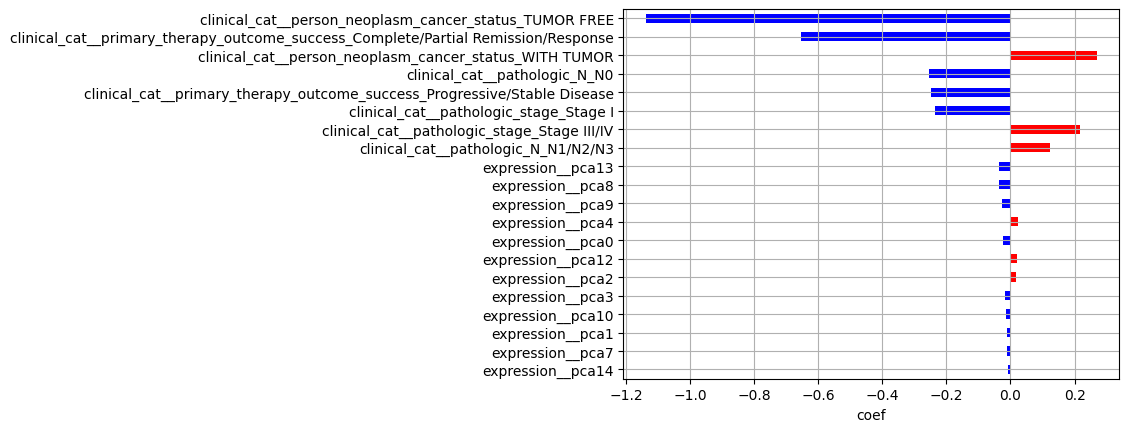

In [20]:
max_n_coefs = 20
if len(best_coefs_non_zero) > 0:
    _ = deepcopy(best_coefs_non_zero)
    if len(_) > max_n_coefs:
        _ = _[:max_n_coefs]
    _ = _[::-1]
    ax = _.plot.barh(
        legend=False, 
        color = (_ > 0).map({True: 'red', False: 'blue'}),
    )
    ax.set_xlabel("coef")
    ax.grid(True)

# cv results

In [21]:
cv_results = pd.DataFrame(cls.cv_results_)

In [22]:
# filter cv_results to get the alphas for the best values of the other params
for param in cls.best_params_:
    if param == 'coxnet__alphas':
        continue
    col = f'param_{param}'
    cv_results = cv_results.loc[cv_results[col] == cls.best_params_[param], :]

In [23]:
cv_results.loc[:, cv_results.columns.str.startswith('param_')].head(5)

,param_preprocess__expression__varthresh__threshold,param_preprocess__expression__select__n_components,param_preprocess__clinical_num__select__k,param_preprocess__clinical_cat__select__k,param_preprocess__clinical_cat__impute__strategy,param_coxnet__l1_ratio,param_coxnet__alphas
1110,3.5,15,0,8,constant,0.1,[0.10000000000000003]
1712,3.5,15,0,8,constant,0.1,[0.017782794100389243]
7725,3.5,15,0,8,constant,0.1,[0.010000000000000007]


      alpha      mean       std
0  0.010000  0.770570  0.027203
1  0.017783  0.769268  0.025168
2  0.100000  0.761470  0.024358
(3, 3)


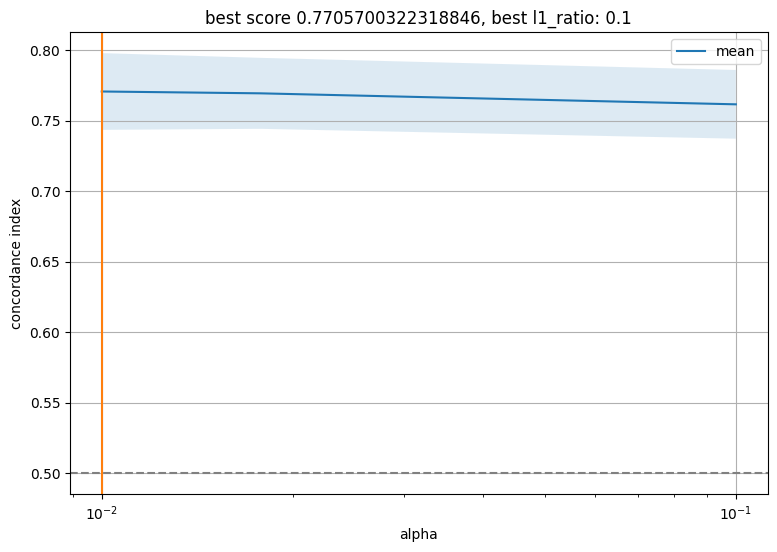

In [24]:
if cv_results.shape[0] > 1: # don't plot if there is only one alpha
    df = pd.DataFrame({
        'alpha': cv_results.param_coxnet__alphas.map(lambda x: x[0]), # 'unlist' each alpha value
        'mean': cv_results.mean_test_score,
        'std': cv_results.std_test_score,
    }).sort_values('alpha').reset_index(drop=True)
    print(df.head())
    print(df.shape)

    best_alpha = cls.best_params_["coxnet__alphas"][0]
    best_l1_ratio = cls.best_params_["coxnet__l1_ratio"]
    best_score = cls.best_score_

    ax = df.plot(x='alpha', y='mean', figsize=(9, 6))
    ax.fill_between(df['alpha'], df['mean'] - df['std'], df['mean'] + df['std'], alpha=0.15)
    ax.set_xscale("log")
    ax.set_ylabel("concordance index")
    ax.set_xlabel("alpha")
    ax.set_title(f'best score {best_score}, best l1_ratio: {best_l1_ratio}')
    ax.axvline(best_alpha, c="C1")
    ax.axhline(0.5, color="grey", linestyle="--")
    ax.grid(True)


# clinical features

In [25]:
clinical_coefs = best_coefs[best_coefs.index.str.startswith('clinical')]
clinical_coefs = clinical_coefs[clinical_coefs.abs().sort_values(ascending=False).index]
clinical_coefs.iloc[:3]

clinical_cat__person_neoplasm_cancer_status_TUMOR FREE                              -1.137868
clinical_cat__primary_therapy_outcome_success_Complete/Partial Remission/Response   -0.653521
clinical_cat__person_neoplasm_cancer_status_WITH TUMOR                               0.269815
dtype: float64

<module 'matplotlib.pyplot' from '/Users/darrenkidney/github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

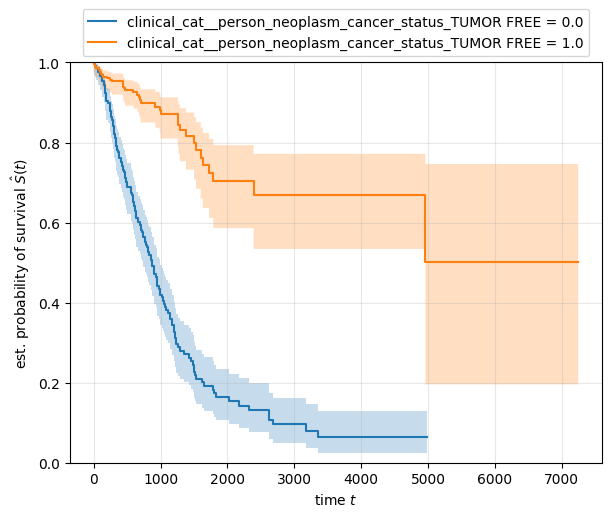

In [26]:
# top ranked clinical feature
df = pd.DataFrame(
    best_model.named_steps['preprocess'].transform(X),
    columns=best_coefs.index,
    index=X.index
)
df = survival[[event_col, time_col]]\
    .merge(df, how='inner', left_index=True, right_index=True)

plot_kaplan_meier(df, clinical_coefs.index[0])


# expression features

In [27]:
expression_coefs = best_coefs[best_coefs.index.str.startswith('expression')]
expression_coefs.iloc[:3]

expression__pca0   -0.024147
expression__pca1   -0.011929
expression__pca2    0.018134
dtype: float64

In [28]:
# PCA loadings
X_pca = pd.DataFrame(
    best_model.named_steps['preprocess']['expression'].transform(X[expression_cols]),
    columns=best_model.named_steps['preprocess']['expression'].get_feature_names_out(),
    index=X.index
)
print(X_pca.iloc[:3, :3])
X_pca.shape

                     pca0       pca1       pca2
TCGA-69-7978-01 -8.227135 -12.557210   2.449491
TCGA-62-8399-01 -3.044011  -0.128876  -6.610666
TCGA-78-7539-01 -2.227730   2.867119 -16.610313


(506, 15)

In [29]:
expression_cols_mask = best_model.named_steps['preprocess']['expression']['varthresh'].get_support()
expression_cols_selected = expression_cols[expression_cols_mask]
print(expression_cols_selected[:3])
len(expression_cols_selected)

Index(['HIF3A', 'COL7A1', 'FAM183A'], dtype='object')


1126

In [30]:
# pca loadings
W = pd.DataFrame(
    best_model.named_steps['preprocess']['expression']['select'].components_,
    columns=expression_cols_selected,
    index=best_model.named_steps['preprocess']['expression'].get_feature_names_out(),
)
print(W.iloc[:3, :3])
W.shape

         HIF3A    COL7A1   FAM183A
pca0  0.020747 -0.018741  0.049571
pca1  0.035420 -0.019692 -0.011114
pca2 -0.002873  0.064999  0.058139


(15, 1126)

In [31]:
# gene-level importance
gamma = pd.Series(
    W.to_numpy().T @ expression_coefs.to_numpy(),
    index=W.columns
)
print(gamma[:3])
gamma.shape

HIF3A     -0.001136
COL7A1     0.003454
FAM183A   -0.000501
dtype: float64


(1126,)

In [32]:
gene_importance = gamma[gamma.abs().sort_values(ascending=False).index]
print(gene_importance[:3])
gene_importance.shape

MUC5B     0.006852
AHNAK2    0.006713
DKK1      0.006152
dtype: float64


(1126,)

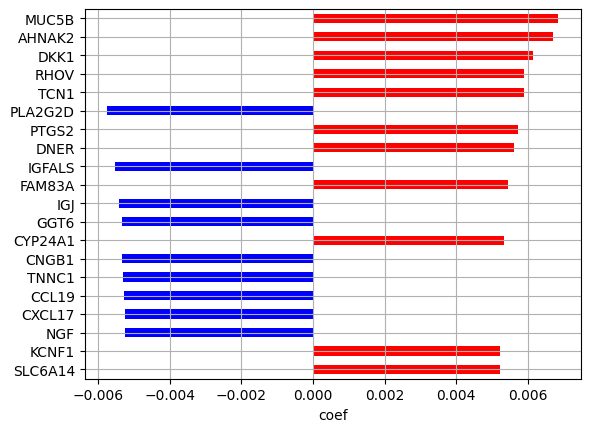

In [33]:
max_n_genes = 20
_ = deepcopy(gene_importance)
_ = _[_.abs().sort_values(ascending=False).index]
if len(_) > max_n_genes:
    _ = _[:max_n_genes]
_ = _[::-1]
ax = _.plot.barh(
    legend=False, 
    color = (_ > 0).map({True: 'red', False: 'blue'}),
)
ax.set_xlabel("coef")
ax.grid(True)

In [35]:
# prepare df for making k-m plots
km_df = survival[[event_col, time_col]]\
    .merge(X, how='inner', left_index=True, right_index=True)

<module 'matplotlib.pyplot' from '/Users/darrenkidney/github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

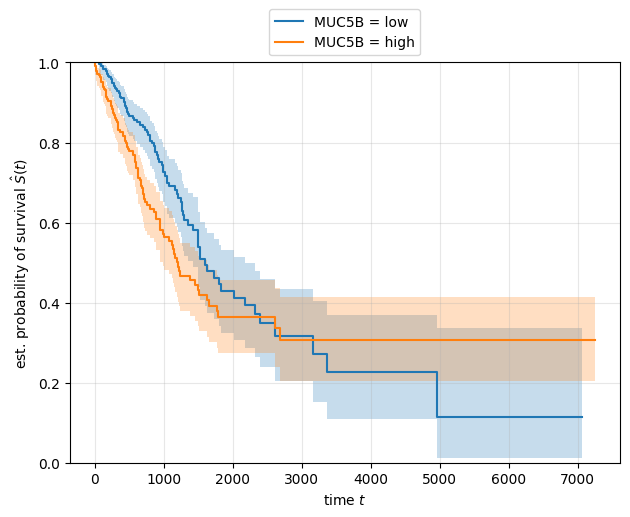

In [36]:
# top ranked gene with a positive coefficient (higher expression associated with decreased survival)
plot_kaplan_meier(km_df, gene_importance.idxmax())

<module 'matplotlib.pyplot' from '/Users/darrenkidney/github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

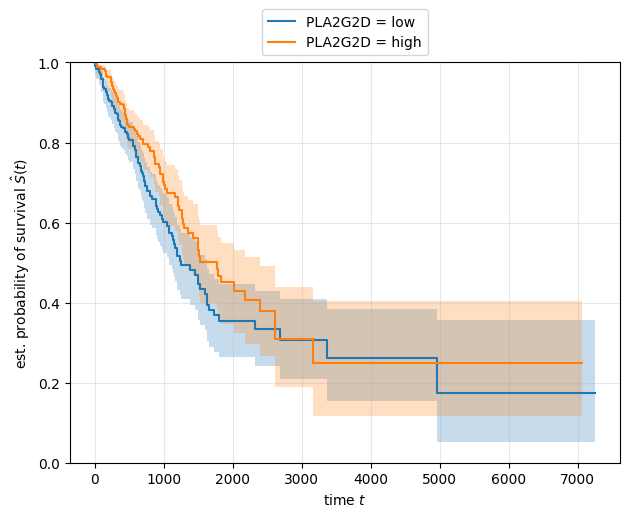

In [37]:
# top ranked gene with a negative coefficient (higher expression associated with increased survival)
plot_kaplan_meier(km_df, gene_importance.idxmin())